In [5]:
from typing import List, Union
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from collections import Counter
from sklearn import model_selection, linear_model, svm, naive_bayes, tree, ensemble
import itertools
import tensorflow as tf
import os

sns.set_style("darkgrid")

Import data

In [6]:
train_df = pd.read_csv("./data/train.csv")
submit_df = pd.read_csv("./data/test.csv")

## Data exploration

In [7]:
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We can also extract passenger titles from names such as Mr., Miss, etc.

In [8]:
def get_titles(series: pd.Series) -> pd.Series:
    return (series
            .str.split(',').apply(lambda x: x[1])
            .str.split('.').apply(lambda x: x[0]))


train_df['Title'] = get_titles(train_df['Name'])

In [9]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Key insights:
1. The dataset is quite small having only 891 entries
1. Baseline for the model: Predict that none passangers survived and it will yield accuracy of 42%, since we see that only 38% of passengers survived
1. Not all entries contain ages of passengers
1. On average 1 in 2 passengers had a sibling or spouse on board and 1 in 3 have a family member (blood related)

In [10]:
train_df.isna().sum().to_frame().T

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,0,0,0,0,0,177,0,0,0,0,687,2,0


Missing alot of cabain numbers, but such information is most likeley not useful for prediction anyways, as we have better variables that suggest about the cabains location or quality - Fare and Ticket class.

Age on the other hand might be a crucial feature, based on the rule "Childern and Women first". We should try some solutions for it. Removing missing data does not seem good as it accounts for 20% of training data. I will try to populate with average value and create a predictor

As for Embarked, only 2 missing data points, we can easily remove or assign the mode value, as i fail to see that this could be a crucial feature for predictions

In [11]:
Counter(train_df['Embarked'])

Counter({'S': 644, 'C': 168, 'Q': 77, nan: 2})

In [12]:
Counter(train_df['Sex'])

Counter({'male': 577, 'female': 314})

In [13]:
Counter(train_df['Title'])

Counter({' Mr': 517,
         ' Mrs': 125,
         ' Miss': 182,
         ' Master': 40,
         ' Don': 1,
         ' Rev': 6,
         ' Dr': 7,
         ' Mme': 1,
         ' Ms': 1,
         ' Major': 2,
         ' Lady': 1,
         ' Sir': 1,
         ' Mlle': 2,
         ' Col': 2,
         ' Capt': 1,
         ' the Countess': 1,
         ' Jonkheer': 1})

After a bit of googling it seems that all of the titles are correct, just based on different origins

Lets first observe if some features are alone good predictors

In [14]:
train_df.pivot_table(columns='Survived')

Survived,0,1
Age,30.626179,28.343690
Fare,22.117887,48.395408
Parch,0.329690,0.464912
PassengerId,447.016393,444.368421
Pclass,2.531876,1.950292
SibSp,0.553734,0.473684


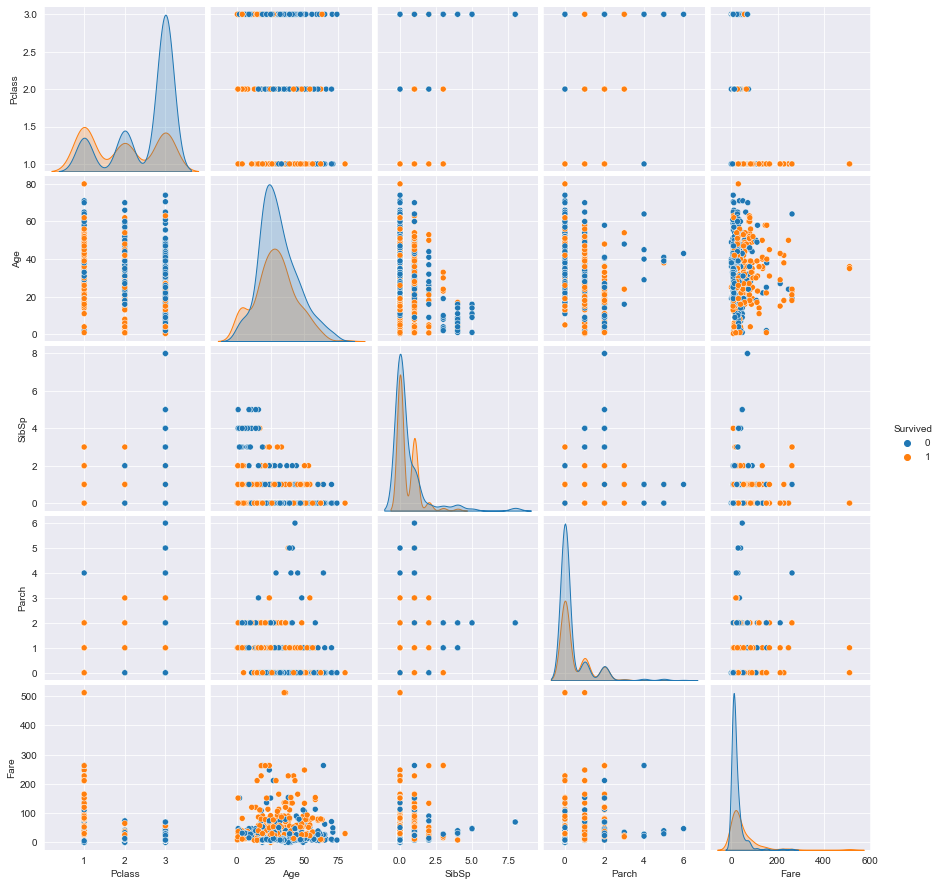

In [15]:
sns.pairplot(train_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived']],
             hue="Survived")

1. People who paid most and had the highest class tickets, were most likely to survive
1. Passengers with more reletives were more likely to not survive, however the pairplot also shows that this is a causation not correlation, as more reletives ~ lower class and cheaper tickets

<AxesSubplot:xlabel='Age', ylabel='Count'>

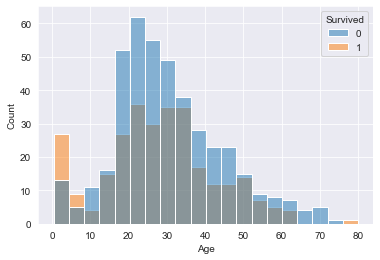

In [16]:
sns.histplot(data=train_df, x='Age', hue="Survived")

<AxesSubplot:xlabel='Sex', ylabel='Count'>

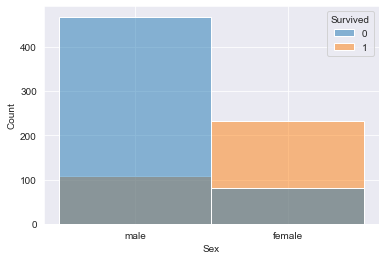

In [17]:
sns.histplot(data=train_df, x='Sex', hue="Survived")

<AxesSubplot:xlabel='Title', ylabel='Count'>

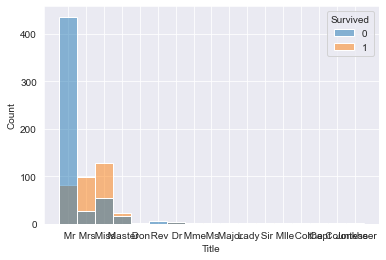

In [18]:
sns.histplot(data=train_df, x='Title', hue="Survived")

The Histograms agree with the common saying "Children and women first" when trying to save people from disasters

## Data cleaning

Need to:
1. Remove cabain, name, ticket columns, set passenger id as index
1. Fill in missing data for Age and Embark
1. Standardize data as we will most likely want to use regularization and SVMs (Age, Fare)
(Both seem to have a gaussian distribution, with Fare having a bit more extreme values)

Categorical values will be one hot encoded in the end

In [19]:
clean_df = train_df.copy()

In [20]:
clean_df = clean_df.drop(['Name', 'Cabin', 'Ticket'], axis=1)
clean_df = clean_df.set_index('PassengerId')

In [21]:
mu_age, std_age = clean_df['Age'].mean(), clean_df['Age'].std()
mu_fare, std_fare = clean_df['Fare'].mean(), clean_df['Fare'].std()

mode_embark = clean_df['Embarked'].mode()[0]

clean_df['Embarked'] = clean_df['Embarked'].fillna(mode_embark)
# Keep values saved as they need to be used for test and prediction data

In [22]:
def one_hot_encode(
    df: pd.DataFrame, columns: List[str] = ['Pclass', 'Sex', 'Embarked', 'Title']
) -> pd.DataFrame:
    return pd.get_dummies(df, columns=columns)

In [23]:
clean_df_one_hot = one_hot_encode(clean_df)
cols_order = clean_df_one_hot.columns  # retain columns ordering
clean_df_no_nan = clean_df_one_hot.dropna()
clean_df_missing_age = clean_df_one_hot[clean_df_one_hot['Age'].isna()].drop(
    'Age', axis=1)


linear_model_age = linear_model.LinearRegression()

linear_model_age.fit(X=clean_df_no_nan.drop('Age', axis=1),
                     y=clean_df_no_nan['Age'])

predicted_age = linear_model_age.predict(clean_df_missing_age)

In [24]:
def overwrite_missing_age(
    missing_age_df: pd.DataFrame, series_or_vlaue: Union[pd.Series, float], col_order: List[str]
) -> pd.DataFrame:

    return_df = missing_age_df.copy()
    return_df['Age'] = series_or_vlaue
    return return_df[col_order]

In [25]:
clean_df_mean_age = overwrite_missing_age(
    clean_df_missing_age, mu_age, cols_order)

clean_df_impute_age = overwrite_missing_age(
    clean_df_missing_age, predicted_age, cols_order)

df_mean_age = pd.concat([clean_df_no_nan, clean_df_mean_age])
df_impute_age = pd.concat([clean_df_no_nan, clean_df_impute_age])

In [26]:
def standardize_series(series: pd.Series, mu, std) -> pd.Series:
    return (series - mu) / std

In [27]:
df_mean_age['Age'] = standardize_series(df_mean_age['Age'], mu_age, std_age)
df_mean_age['Fare'] = standardize_series(
    df_mean_age['Fare'], mu_fare, std_fare)

In [28]:
df_impute_age['Age'] = standardize_series(
    df_impute_age['Age'], mu_age, std_age)
df_impute_age['Fare'] = standardize_series(
    df_impute_age['Fare'], mu_fare, std_fare)

## Predictions

In [29]:
train_df, test_df = model_selection.train_test_split(
    df_mean_age, test_size=0.2, random_state = 666)
# Lets keep the split rows same in both mean age df and imputed age df
train_df_imp = df_impute_age.loc[df_impute_age.index.isin(train_df.index)]
test_df_imp = df_impute_age.loc[df_impute_age.index.isin(test_df.index)]

In [30]:
train_df

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,...,Title_ Master,Title_ Miss,Title_ Mlle,Title_ Mme,Title_ Mr,Title_ Mrs,Title_ Ms,Title_ Rev,Title_ Sir,Title_ the Countess
PassengerId,,,,,,,,,,,,,,,,,,,,,
30,0,0.000000,0,0,-0.489167,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
532,0,0.000000,0,0,-0.502582,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
891,0,0.158392,0,0,-0.492101,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
829,1,0.000000,0,0,-0.492101,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
149,0,0.468171,0,2,-0.124850,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,1,0.020713,0,0,1.233479,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
92,0,-0.667685,0,0,-0.490005,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
564,0,0.000000,0,0,-0.486064,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0


We want to classify if a person would have died or not in the titanic disaster.

It is a two class classification problem, so appropriate models would be:
1. Logistic regression
1. SVM machine
1. Naive Bayes
1. Decision tree / forest
1. Neural network (Why not)

### Logistic regression

In [33]:
Cs = np.arange(0.1, 5.1, 0.1)
reg_ratios = np.linspace(0.1, 1, 10)

log_model_l1 = linear_model.LogisticRegressionCV(
    Cs=Cs, penalty='l1', solver='liblinear')
log_model_l2 = linear_model.LogisticRegressionCV(
    Cs=Cs, penalty='l2', solver='liblinear')
log_model_elastic = linear_model.LogisticRegressionCV(
    Cs=Cs, penalty='elasticnet', solver='saga', l1_ratios=reg_ratios, max_iter=500)

In [34]:
log_model_l1.fit(train_df.drop('Survived', axis=1), train_df['Survived'])
print("log_model_l1 trained")
log_model_l2.fit(train_df.drop('Survived', axis=1), train_df['Survived'])
print("log_model_l2 trained")
log_model_elastic.fit(train_df.drop('Survived', axis=1), train_df['Survived'])
print("log_model_elastic trained")

log_model_l1 trained
log_model_l2 trained
log_model_elastic trained


In [35]:
def model_evaluation(model, train_df, test_df):
    train_acc = model.score(train_df.drop(
        'Survived', axis=1), train_df['Survived'])
    test_acc = model.score(test_df.drop(
        'Survived', axis=1), test_df['Survived'])

    x_df = pd.DataFrame((model.feature_names_in_, model.coef_[0])).T
    x_df.columns = ['name', 'coef']
    top_10_features = x_df.sort_values(
        'coef', key=abs, ascending=False).head(10)

    print(f"""
    -----------------------------------------------------
    Parameters:
        C: {model.C_}
        l1 ratio: {model.l1_ratio_}
    
    Intercept: {model.intercept_}
    Top 10 coeficients: 
    {top_10_features.to_string(index=False,header=False)}
    
    Train / Test accuracy 
    {round(train_acc*100,2)}% / {round(test_acc*100,2)}%
    -----------------------------------------------------
    
    """)

In [36]:
print('Log model with Lasso regularization')
model_evaluation(log_model_l1, train_df, test_df)
print('Log model with Ridge regularization')
model_evaluation(log_model_l2, train_df, test_df)
print('Log model with Elastic regularization')
model_evaluation(log_model_elastic, train_df, test_df)

Log model with Lasso regularization

    -----------------------------------------------------
    Parameters:
        C: [1.4]
        l1 ratio: [None]
    
    Intercept: [0.]
    Top 10 coeficients: 
    Title_ Master  3.014709
   Sex_female  1.753756
     Sex_male -1.093226
     Pclass_3 -0.992658
     Pclass_1  0.793195
        SibSp -0.505027
   Title_ Mrs  0.458582
   Embarked_C  0.365248
   Title_ Rev -0.269068
          Age  -0.24224
    
    Train / Test accuracy 
    83.15% / 82.68%
    -----------------------------------------------------
    
    
Log model with Ridge regularization

    -----------------------------------------------------
    Parameters:
        C: [1.1]
        l1 ratio: [None]
    
    Intercept: [0.28525893]
    Top 10 coeficients: 
    Title_ Master  2.015045
   Sex_female  1.177126
     Pclass_1  0.921164
     Sex_male -0.891867
    Title_ Mr -0.816122
   Title_ Rev -0.815678
     Pclass_3 -0.806851
   Title_ Mrs   0.61023
   Title_ Don -0.524252
  

We get around 82% accuracy on test data with small difference between regularization models.

We also see that Sex, title and class were amongst the most important features.

Can we get better results using imputed age instead of mean age ?

In [37]:
Cs = np.arange(0.1, 5.1, 0.1)
reg_ratios = np.linspace(0.1, 1, 5)

log_model_l1 = linear_model.LogisticRegressionCV(
    Cs=Cs, penalty='l1', solver='liblinear')
log_model_l2 = linear_model.LogisticRegressionCV(
    Cs=Cs, penalty='l2', solver='liblinear')
log_model_elastic = linear_model.LogisticRegressionCV(
    Cs=Cs, penalty='elasticnet', solver='saga', l1_ratios=reg_ratios, max_iter=500)

In [38]:
log_model_l1.fit(train_df_imp.drop('Survived', axis=1),
                 train_df_imp['Survived'])
print("log_model_l1 trained")
log_model_l2.fit(train_df_imp.drop('Survived', axis=1),
                 train_df_imp['Survived'])
print("log_model_l2 trained")
log_model_elastic.fit(train_df_imp.drop(
    'Survived', axis=1), train_df_imp['Survived'])
print("log_model_elastic trained")

log_model_l1 trained
log_model_l2 trained
log_model_elastic trained


In [39]:
print('Log model with Lasso regularization')
model_evaluation(log_model_l1, train_df_imp, test_df_imp)
print('Log model with Ridge regularization')
model_evaluation(log_model_l2, train_df_imp, test_df_imp)
print('Log model with Elastic regularization')
model_evaluation(log_model_elastic, train_df_imp, test_df_imp)

Log model with Lasso regularization

    -----------------------------------------------------
    Parameters:
        C: [2.8]
        l1 ratio: [None]
    
    Intercept: [0.]
    Top 10 coeficients: 
    Title_ Master  2.827947
   Sex_female  1.802068
     Pclass_3 -1.068525
   Title_ Rev -1.060842
     Pclass_1  0.979086
     Sex_male -0.929085
   Title_ Don -0.645859
   Title_ Mrs  0.616855
        SibSp -0.554797
          Age -0.408375
    
    Train / Test accuracy 
    83.15% / 83.24%
    -----------------------------------------------------
    
    
Log model with Ridge regularization

    -----------------------------------------------------
    Parameters:
        C: [1.3]
        l1 ratio: [None]
    
    Intercept: [0.30055757]
    Top 10 coeficients: 
    Title_ Master  1.942184
   Sex_female  1.209535
     Pclass_1  1.065797
     Sex_male -0.908977
     Pclass_3 -0.899465
   Title_ Rev -0.841828
    Title_ Mr -0.762152
   Title_ Mrs  0.706888
   Title_ Don  -0.59975
  

With imputed age dataframe we get up to 2% better results

### SVM machine

In [40]:
# SVM do not have built in way to determine best regularization param,
# So we do it ourselves

In [41]:
def train_svm(Cs, train_df):
    rbf_score = 0
    lin_score = 0

    for c in Cs:
        svc_rbf = svm.SVC(C=c, kernel='rbf')
        svc_lin = svm.SVC(C=c, kernel='linear')

        rbf_score_c = model_selection.cross_val_score(svc_rbf, train_df.drop(
            'Survived', axis=1), train_df['Survived'], cv=5, scoring='accuracy')
        lin_score_c = model_selection.cross_val_score(svc_lin, train_df.drop(
            'Survived', axis=1), train_df['Survived'], cv=5, scoring='accuracy')

        if rbf_score < rbf_score_c.mean():
            rbf_c = c
            rbf_score = rbf_score_c.mean()

        if lin_score < lin_score_c.mean():
            lin_c = c
            lin_score = lin_score_c.mean()

    svc_rbf = svm.SVC(C=rbf_c, kernel='rbf')
    svc_rbf.fit(train_df.drop('Survived', axis=1), train_df['Survived'])

    svc_lin = svm.SVC(C=lin_c, kernel='linear')
    svc_lin.fit(train_df.drop('Survived', axis=1), train_df['Survived'])

    return svc_rbf, svc_lin

In [42]:
def evaluate_svm(model, train_df, test_df):
    train_acc = model.score(train_df.drop(
        'Survived', axis=1), train_df['Survived'])
    test_acc = model.score(test_df.drop(
        'Survived', axis=1), test_df['Survived'])

    print(f"""
    -----------------------------------------------------
    Parameters:
        C: {model.C}
    
    Train / Test accuracy 
    {round(train_acc*100,2)}% / {round(test_acc*100,2)}%
    -----------------------------------------------------
    """)

In [43]:
Cs = np.arange(0.1, 5.1, 0.1)
svc_rbf, svc_lin = train_svm(Cs, train_df)

print("SVM with rbf kernal evaulation")
evaluate_svm(svc_rbf, train_df, test_df)
print("SVM with linear kernal evaulation")
evaluate_svm(svc_lin, train_df, test_df)

SVM with rbf kernal evaulation

    -----------------------------------------------------
    Parameters:
        C: 1.1
    
    Train / Test accuracy 
    84.27% / 82.68%
    -----------------------------------------------------
    
SVM with linear kernal evaulation

    -----------------------------------------------------
    Parameters:
        C: 0.2
    
    Train / Test accuracy 
    83.29% / 81.01%
    -----------------------------------------------------
    


We can see accuracy results of 81-82% using mean age training df, which is better than Logistic regression. Lets try out the other training dataframe

In [44]:
Cs = np.arange(0.1, 5.1, 0.1)
svc_rbf, svc_lin = train_svm(Cs, train_df_imp)

In [45]:
print("SVM with rbf kernal evaulation")
evaluate_svm(svc_rbf, train_df_imp, test_df_imp)
print("SVM with linear kernal evaulation")
evaluate_svm(svc_lin, train_df_imp, test_df_imp)

SVM with rbf kernal evaulation

    -----------------------------------------------------
    Parameters:
        C: 0.8
    
    Train / Test accuracy 
    83.85% / 82.68%
    -----------------------------------------------------
    
SVM with linear kernal evaulation

    -----------------------------------------------------
    Parameters:
        C: 0.30000000000000004
    
    Train / Test accuracy 
    83.29% / 81.01%
    -----------------------------------------------------
    


This model is less sensitive to mean vs. imputed dataframes, but the imputed one again outputs a model with higher accuracy of ~89%

We can also see that radial basis function kernel yields better results in training and testing

### Naive Bayes

In [46]:
gaussian_nb = naive_bayes.GaussianNB()

In [47]:
def gaussian_model(model, train_df, test_df):
    model.fit(train_df.drop(
        'Survived', axis=1), train_df['Survived'])
    print("Gaussian Naive Bayes classifier scores:")
    print(
        f"Train: {round(model.score(train_df.drop('Survived', axis=1), train_df['Survived'])*100,2)} %")
    print(
        f"Test: {round(model.score(test_df.drop('Survived', axis=1), test_df['Survived'])*100,2)} %")
    return model

In [48]:
print("Mean age dataframe results")
gaussian_model(gaussian_nb, train_df, test_df)
print("--------------------------------------")
print("Imputed age dataframe results")
gaussian_model(gaussian_nb, train_df_imp, test_df_imp)
print("--------------------------------------")

Mean age dataframe results
Gaussian Naive Bayes classifier scores:
Train: 81.74 %
Test: 75.98 %
--------------------------------------
Imputed age dataframe results
Gaussian Naive Bayes classifier scores:
Train: 81.74 %
Test: 75.98 %
--------------------------------------


As expected Naive Bayes model does not provide better results as other models

### Decision trees and forests

First lets build a most basic decision tree and then we will try and prune it

In [49]:
descision_tree = tree.DecisionTreeClassifier()

In [50]:
descision_tree.fit(train_df.drop('Survived', axis=1), train_df['Survived'])
round(descision_tree.score(train_df.drop(
    'Survived', axis=1), train_df['Survived'])*100, 2)

98.46

We get a near perfect accuracy with the full descision tree,
so we can expect (and actually we know) that this tree is overfitting

In [51]:
round(descision_tree.score(test_df.drop(
    'Survived', axis=1), test_df['Survived'])*100, 2)

78.77

The tree does still get a good accuracy on the testing data, but not nearly as good as we see on the training

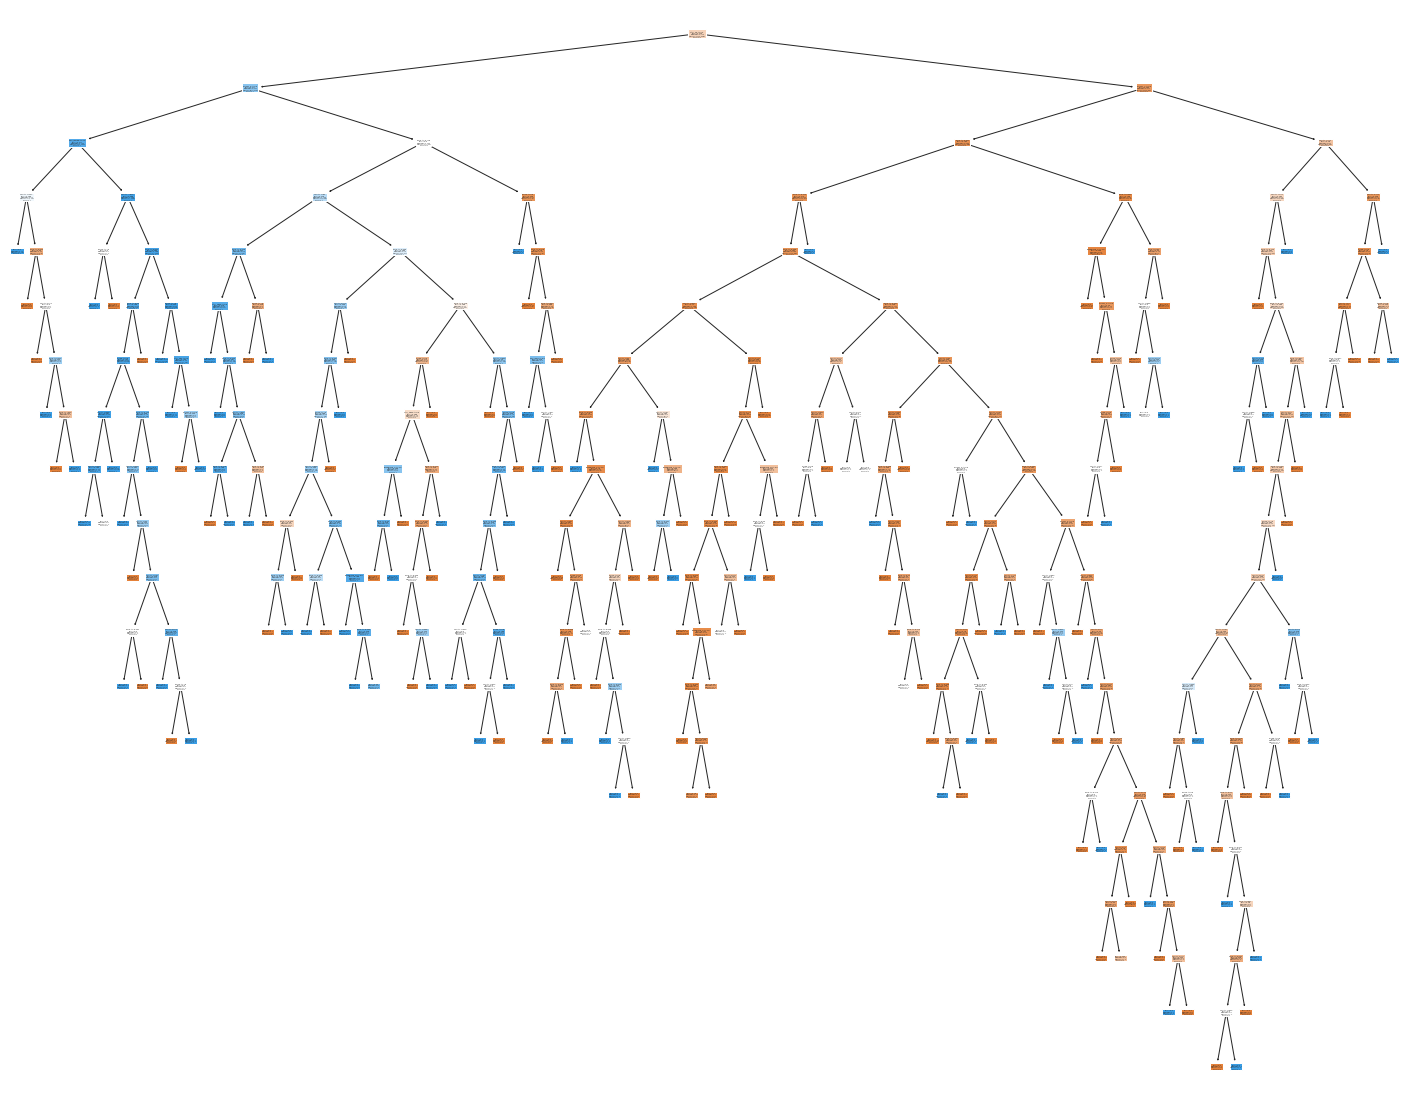

In [57]:
fig_tree = plt.figure(figsize=(25, 20))
_ = tree.plot_tree(descision_tree,
                   feature_names=train_df.drop('Survived', axis=1).columns,
                   class_names=['0', '1'],
                   filled=True)

We see that the tree is very deep, and overfitting

Lets prune the tree and try out different parameter spaces

In [58]:
depths = np.arange(1, descision_tree.get_depth())
kf = model_selection.KFold(n_splits=5,shuffle=True)

In [59]:
gini = []
entrop = []
for d in depths:
    gini_score = []
    entrop_score = []

    for k_train, k_test in kf.split(train_df):
        
        descision_tree_gini = tree.DecisionTreeClassifier(
            criterion='gini', max_depth=d)
        descision_tree_entropy = tree.DecisionTreeClassifier(
            criterion='entropy', max_depth=d)

        train_df_k = train_df[train_df.index.isin(k_train)]
        test_df_k = train_df[train_df.index.isin(k_test)]

        descision_tree_gini.fit(train_df_k.drop(
            'Survived', axis=1), train_df_k['Survived'])
        descision_tree_entropy.fit(train_df_k.drop(
            'Survived', axis=1), train_df_k['Survived'])

        gini_score.append(descision_tree_gini.score(
            test_df_k.drop('Survived', axis=1), test_df_k['Survived']))
        
        entrop_score.append(descision_tree_entropy.score(
            test_df_k.drop('Survived', axis=1), test_df_k['Survived']))

    try:
        if np.mean(gini_score) > max(gini) and np.mean(gini_score) > max(entrop):
            best_tree = descision_tree_gini
        if np.mean(entrop_score) > max(gini) and np.mean(entrop_score) > max(entrop):
            best_tree = descision_tree_entropy
    except ValueError:
        # throws exception when lists are empty - first iteration, we just take the base model
        best_tree = descision_tree_gini

    gini.append(np.mean(gini_score))
    entrop.append(np.mean(entrop_score))

accuracy_df = pd.DataFrame([depths, gini, entrop]).T
accuracy_df.columns = ['depth', 'gini', 'entropy']

<AxesSubplot:xlabel='depth'>

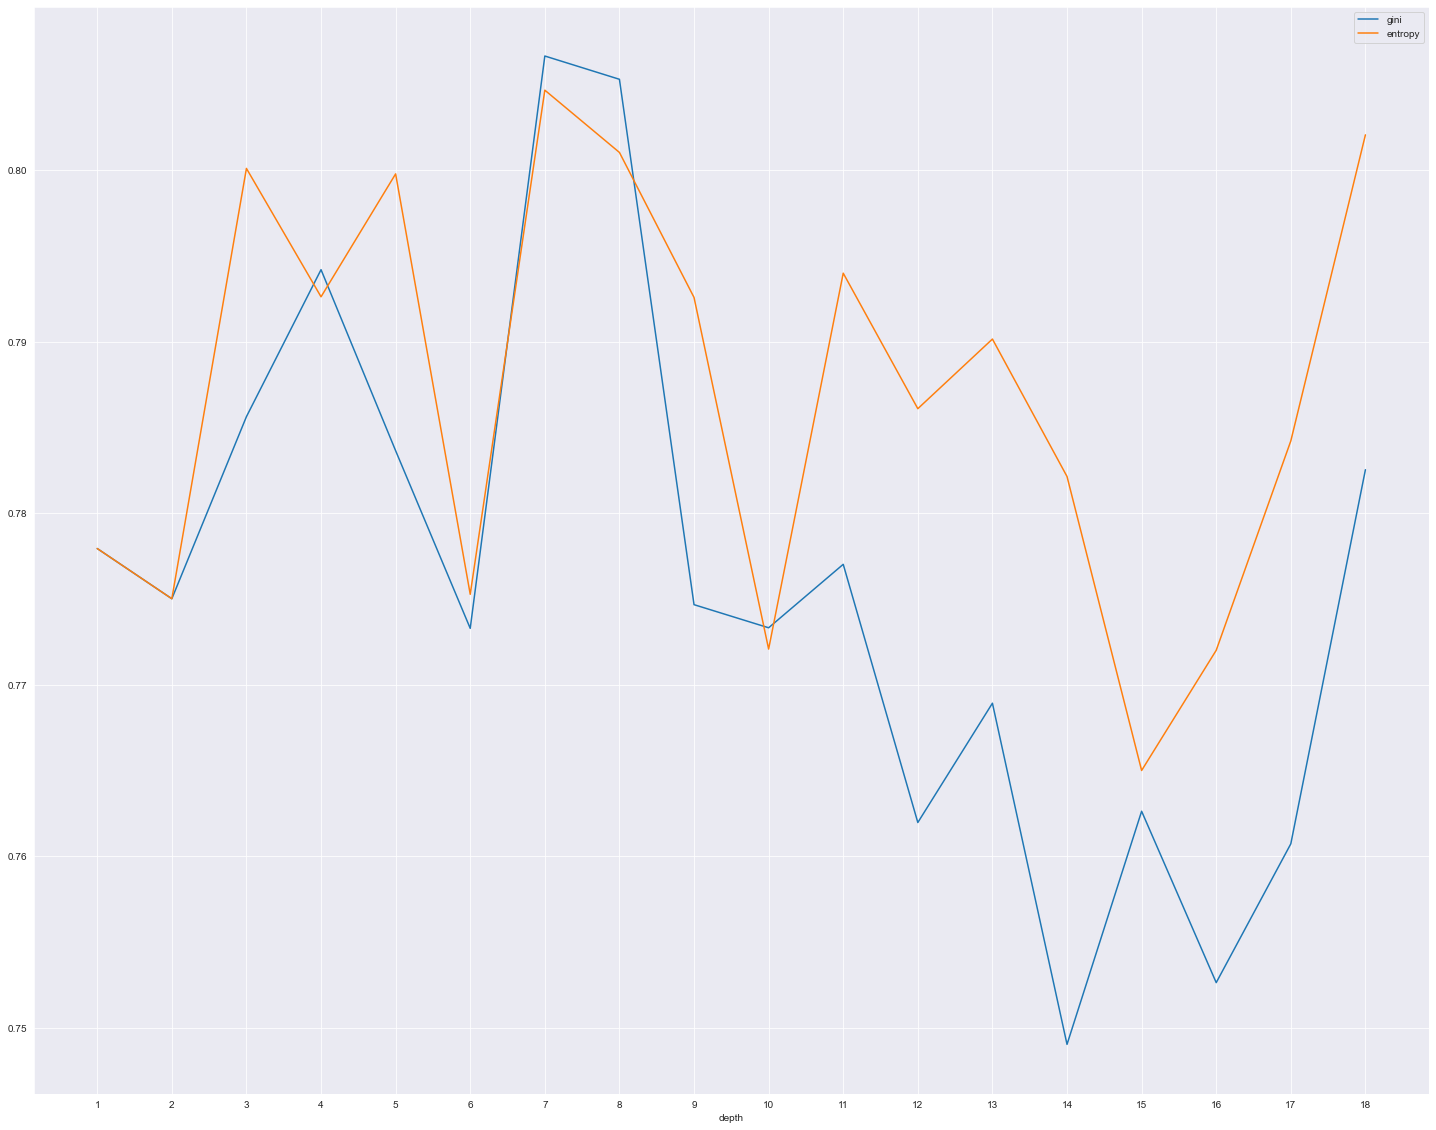

In [60]:
accuracy_df.plot(x='depth', figsize=(25, 20), xticks=depths)

In [61]:
print(f"""Test accuracy of best tree model:
    {round(accuracy_df.drop('depth', axis=1).max().max()*100,2)}%
""")

Test accuracy of best tree model:
    80.66%



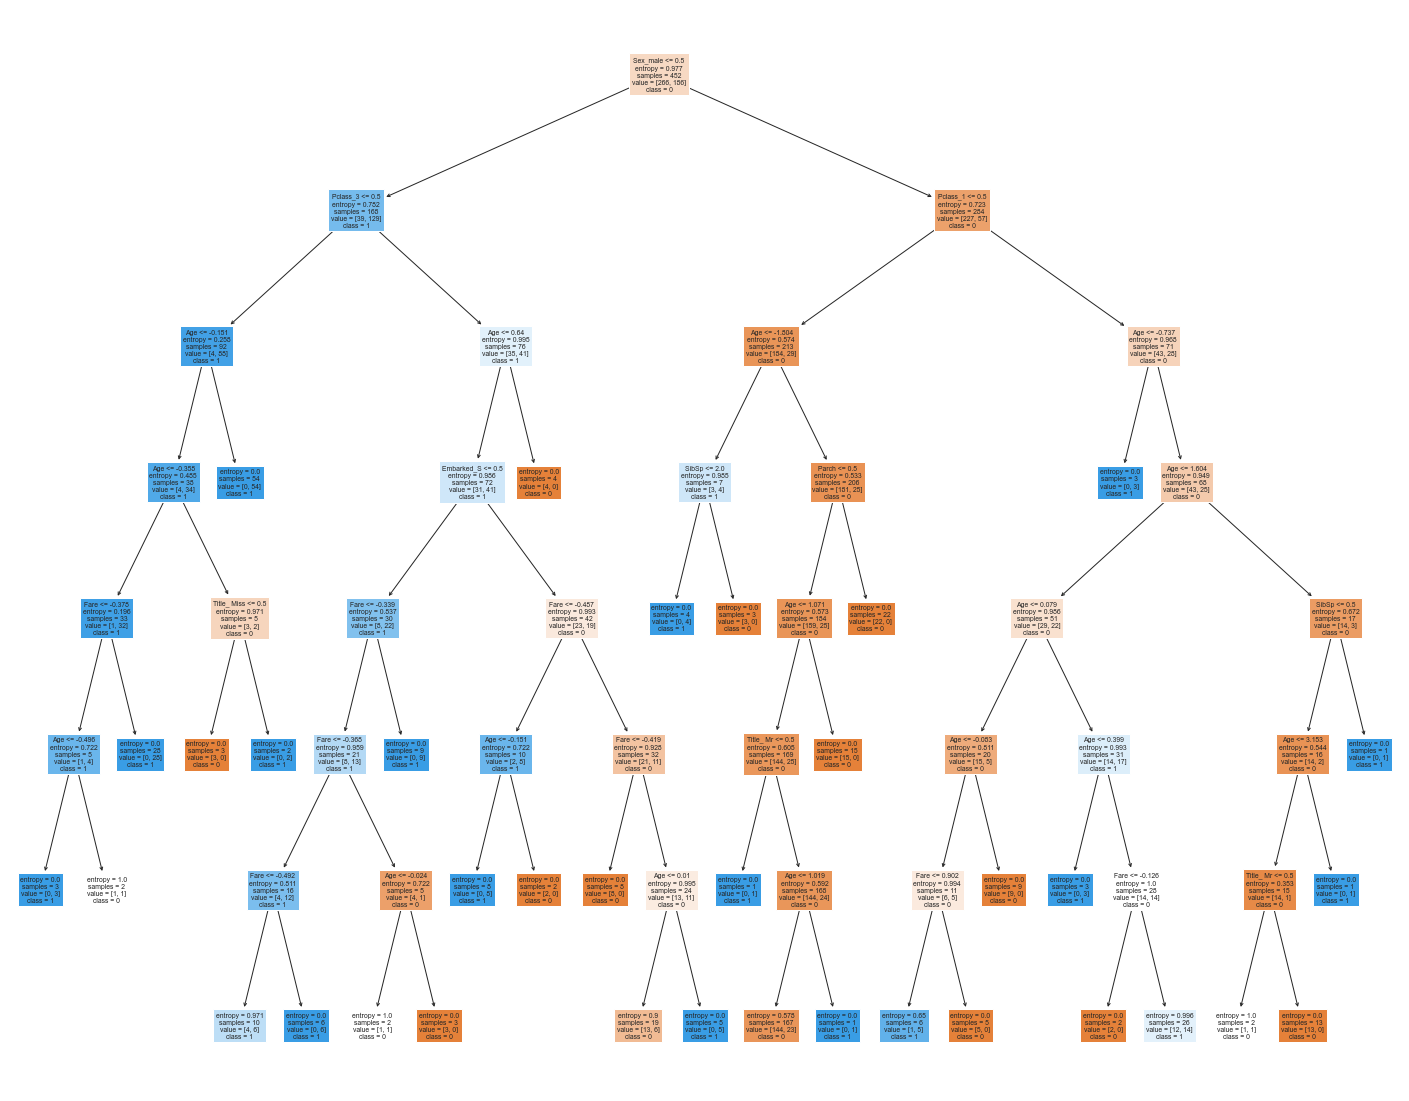

In [62]:
fig_tree = plt.figure(figsize=(25, 20))
_ = tree.plot_tree(best_tree,
                   feature_names=train_df.drop('Survived', axis=1).columns,
                   class_names=['0', '1'],
                   filled=True)

Lets try the random forest approach and a couple of other ensamble models

In [63]:
models = {
    'random_forest': ensemble.RandomForestClassifier(),
    'ada_boost_forest': ensemble.AdaBoostClassifier(),
    'gradiant_boost_forest': ensemble.GradientBoostingClassifier()
}

In [64]:
for name, model in models.items():
    model.fit(train_df.drop(
    'Survived', axis=1), train_df['Survived'])
    train_score = model.score(train_df.drop('Survived', axis=1), train_df['Survived'])
    test_score = model.score(test_df.drop('Survived', axis=1), test_df['Survived'])
    print(f"""{name} scores:
    Train: {round(train_score*100,2)}% / Test: {round(test_score*100,2)}%
    """)
    

random_forest scores:
    Train: 98.46% / Test: 82.12%
    
ada_boost_forest scores:
    Train: 83.85% / Test: 81.01%
    
gradiant_boost_forest scores:
    Train: 90.45% / Test: 83.8%
    


### Neural Networks

Lets try out a Neural Network with a simple architecture

In [91]:
nn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(29),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam',
                 loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])

In [92]:
nn_model.fit(x=train_df_imp.drop('Survived', axis=1),
             y=train_df_imp['Survived'], epochs=20)

Epoch 1/20

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 0s 696us/step - loss: 0.6799 - accuracy: 0.5702
Epoch 2/20
23/23 [==============================] - 0s 696us/step - loss: 0.6192 - accuracy: 0.7669
Epoch 3/20
23/23 [==============================] - 0s 826us/step - loss: 0.5564 - accuracy: 0.7893
Epoch 4/20
23/23 [==============================] - 0s 696us/step - loss: 0.4977 - accuracy: 0.8048
Epoch 5/20
23/23 [==============================] - 0s 783us/step - loss: 0.4578 - accuracy: 0.8090
Epoch 6/

In [93]:
test_loss, test_acc = nn_model.evaluate(test_df.drop(
    'Survived', axis=1),  test_df['Survived'], verbose=2)
print('\nTest accuracy:', test_acc)

6/6 - 0s - loss: 0.3941 - accuracy: 0.8436

Test accuracy: 0.8435754179954529


In [94]:
model_path = os.getcwd() + r'\nn_model'
nn_model.save(model_path)

INFO:tensorflow:Assets written to: C:\Users\juliu\Documents\GitHub\Kaggle-competitions\introductional_competitions\titanic\nn_model\assets


## Sumbission

All models have been explored on a basic level and the best results were given by a 2 hidden layer neural network. We will now use it on the submit data

First We need to use the same data preprocessing on the sumbit data fram

In [103]:
submit_df = pd.read_csv("./data/test.csv")

In [104]:
submit_df.isna().sum().to_frame().T

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,0,0,0,86,0,0,0,1,327,0


Age can be imputed the same way as it was on training data, We do not use the Cabin column, and Fare has only one value missing, we will use mean Fare for it

In [105]:
submit_df_adjusted = submit_df.drop('Cabin', axis=1)
submit_df_adjusted = submit_df_adjusted.set_index('PassengerId', drop=True)
submit_df_adjusted['Title'] = get_titles(submit_df_adjusted['Name'])
submit_df_adjusted = submit_df_adjusted.drop(['Name', 'Ticket'], axis=1)

In [106]:
Counter(submit_df_adjusted['Title'])

Counter({' Mr': 240,
         ' Mrs': 72,
         ' Miss': 78,
         ' Master': 21,
         ' Ms': 1,
         ' Col': 2,
         ' Rev': 2,
         ' Dr': 1,
         ' Dona': 1})

We get an unseen title 'Dona', after googling we see it is spanish title for lady, we can asume she is the lady of the Don, and we can expect they stuck together during the disaster so we will give her the title of a 'Don' 

In [107]:
submit_df_adjusted = submit_df_adjusted.replace(' Dona',' Don')

In [108]:
submit_df_adjusted_one_hot = one_hot_encode(submit_df_adjusted)

# Add missing dummy columns and reorder
for column in train_df:
    if column not in submit_df_adjusted_one_hot.columns:
        print(column + ' added')
        submit_df_adjusted_one_hot[column] = 0

submit_df_adjusted_one_hot = submit_df_adjusted_one_hot[train_df.columns]\

# Add mean fare to not lose this value
submit_df_adjusted_one_hot['Fare'] = submit_df_adjusted_one_hot['Fare'].fillna(
    submit_df_adjusted_one_hot['Fare'].mean())

submit_df_no_nan = submit_df_adjusted_one_hot.dropna()

submit_df_missing_age = submit_df_adjusted_one_hot[submit_df_adjusted_one_hot['Age'].isna()].drop(
    'Age', axis=1)

predicted_age_sumbit = linear_model_age.predict(submit_df_missing_age)
submit_df_age_imputed = overwrite_missing_age(
    submit_df_missing_age, predicted_age_sumbit, cols_order)

submit_df_processed = pd.concat([submit_df_no_nan, submit_df_age_imputed])
submit_df_processed['Age'] = standardize_series(
    submit_df_processed['Age'], mu_age, std_age)
submit_df_processed['Fare'] = standardize_series(
    submit_df_processed['Fare'], mu_age, std_age)


submit_df_processed = submit_df_processed.drop('Survived', axis=1).sort_index()

Survived added
Title_ Capt added
Title_ Jonkheer added
Title_ Lady added
Title_ Major added
Title_ Mlle added
Title_ Mme added
Title_ Sir added
Title_ the Countess added


In [101]:
# Submit NN model
submit_df_processed['Predict'] = nn_model.predict(submit_df_processed)
submit_df_processed['Survived'] = (submit_df_processed['Predict'] > 0.5)*1
submit_formated = submit_df_processed.reset_index()[['PassengerId','Survived']]
submit_formated.to_csv('nn_model_submission.csv',index=False)
!kaggle competitions submit -c titanic -f nn_model_submission.csv -m "NN model submission Age imputed"

Successfully submitted to Titanic - Machine Learning from Disaster



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:02<00:00, 1.55kB/s]


In [73]:
# Submit Gradiant boost model
model_submit = models['gradiant_boost_forest']
submit_df_processed['Predict'] = model_submit.predict(submit_df_processed)
submit_df_processed['Survived'] = (submit_df_processed['Predict'] > 0.5)*1
submit_formated = submit_df_processed.reset_index()[['PassengerId','Survived']]
submit_formated.to_csv('gradiant_boost_model_submission.csv',index=False)
!kaggle competitions submit -c titanic -f gradiant_boost_model_submission.csv -m "gradiant_boost model submission"

Successfully submitted to Titanic - Machine Learning from Disaster



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 22.8kB/s]
100%|##########| 3.18k/3.18k [00:02<00:00, 1.49kB/s]


In [109]:
# Submit Log regression model
submit_df_processed['Predict'] = log_model_elastic.predict(submit_df_processed)
submit_df_processed['Survived'] = (submit_df_processed['Predict'] > 0.5)*1
submit_formated = submit_df_processed.reset_index()[['PassengerId','Survived']]
submit_formated.to_csv('log_regression_model_submission.csv',index=False)
!kaggle competitions submit -c titanic -f log_regression_model_submission.csv -m "Log regression model submission"

Successfully submitted to Titanic - Machine Learning from Disaster



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 22.9kB/s]
100%|##########| 3.18k/3.18k [00:01<00:00, 1.87kB/s]
